In [1]:
## 3. efficientnet_b2 로 random s num_iterations 3 > 총 30번

D:\ANACONDA3_ENVS\DR\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA3_ENVS\DR\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
train Loss: 1.9952 Acc: 0.2784 Recall: 0.2848
val Loss: 2.2939 Acc: 0.2548 Recall: 0.2726

Epoch 1/9
train Loss: 1.8733 Acc: 0.3221 Recall: 0.3316
val Loss: 2.0088 Acc: 0.2382 Recall: 0.2351

Epoch 2/9
train Loss: 1.8490 Acc: 0.3305 Recall: 0.3393
val Loss: 1.7726 Acc: 0.3550 Recall: 0.3529

Epoch 3/9
train Loss: 1.8514 Acc: 0.3264 Recall: 0.3338
val Loss: 1.9855 Acc: 0.2583 Recall: 0.2399

Epoch 4/9
train Loss: 1.8483 Acc: 0.3260 Recall: 0.3324
val Loss: 1.8509 Acc: 0.3067 Recall: 0.2919

Epoch 5/9
train Loss: 1.8243 Acc: 0.3372 Recall: 0.3459
val Loss: 1.8393 Acc: 0.3512 Recall: 0.3498

Epoch 6/9
train Loss: 1.8195 Acc: 0.3425 Recall: 0.3501
val Loss: 1.7622 Acc: 0.3626 Recall: 0.3857

Epoch 7/9
train Loss: 1.8068 Acc: 0.3462 Recall: 0.3528
val Loss: 1.7511 Acc: 0.3603 Recall: 0.3785

Epoch 8/9
train Loss: 1.7973 Acc: 0.3526 Recall: 0.3599
val Loss: 1.7876 Acc: 0.3334 Recall: 0.3184

Epoch 9/9
train Loss: 1.7959 Acc: 0.3565 Recall: 0.3634
val Loss: 1.7920 Acc: 0.3632 Recall

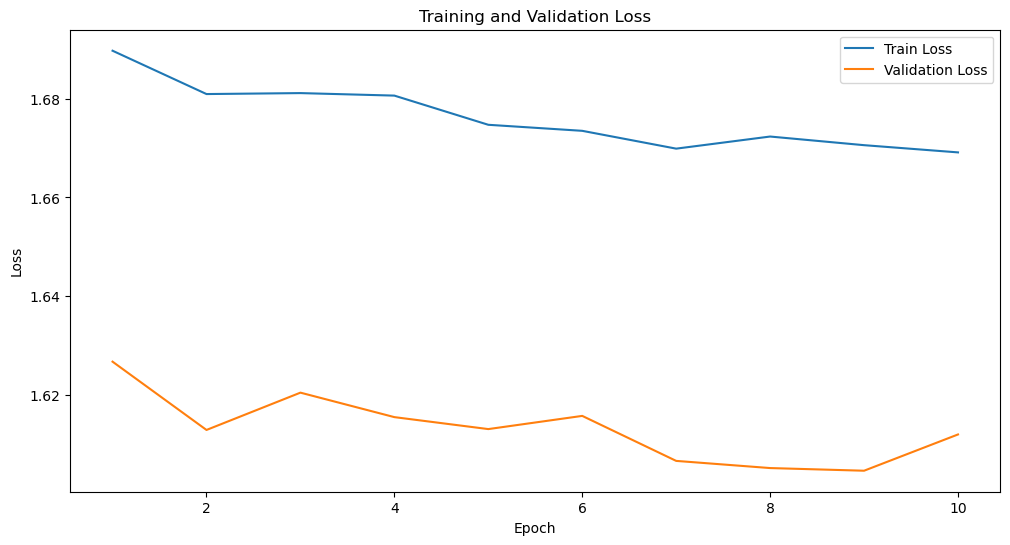

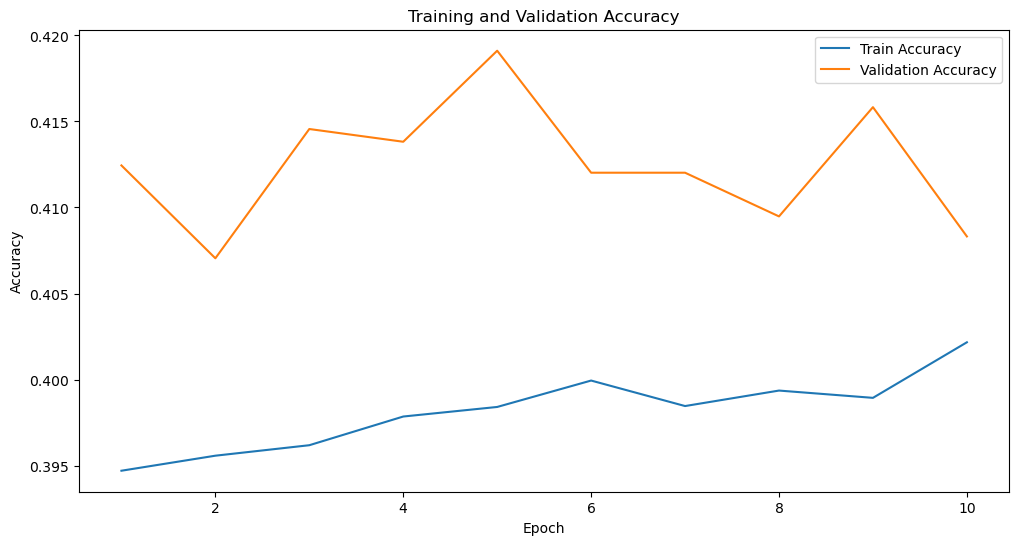

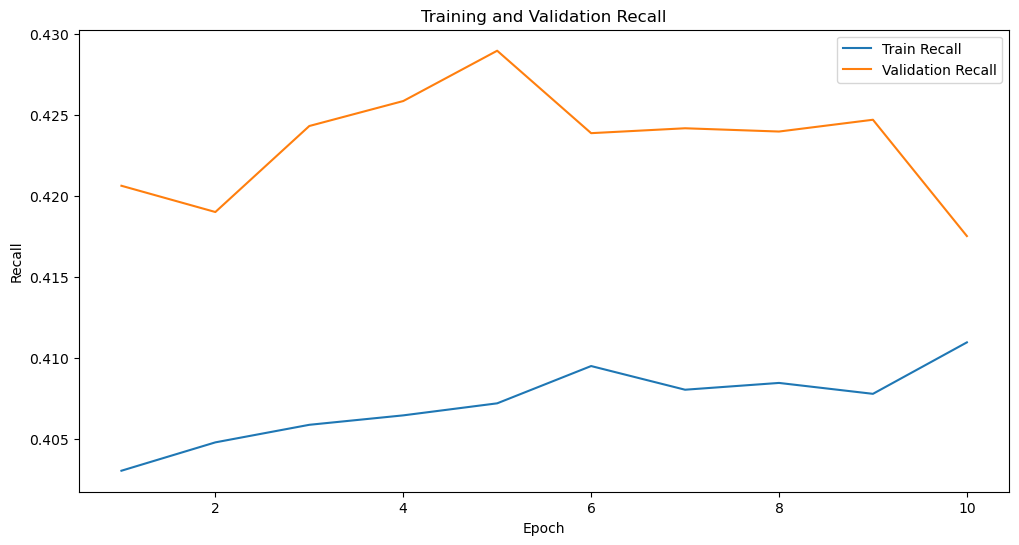

In [2]:
import os  # os 모듈 추가
import time
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# MobileNet 모델 불러오기 및 수정
model = models.efficientnet_b2(pretrained=False) # true > pretrained=False 확인. #@! 
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
# 학습 및 평가 함수
def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_recall_history = []
    val_recall_history = []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
        print(epoch_str)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                # GPU 메모리 정리
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(epoch_recall)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(epoch_recall)
            log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
            print(log_str)
        print()
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history
# Define the hyperparameter search space # 랜덤써치 하이퍼 파라미터 start #@!
learning_rate_range = [10 ** np.random.uniform(-4, -2) for _ in range(100)]  # 10 ** np.random.uniform(-4, -2) 균등분포 #@!
weight_decay_range = [10 ** np.random.uniform(-4, -2) for _ in range(100)]
dropout_range = [0.1, 0.2, 0.3, 0.4, 0.5]
num_epochs = 10  # Number of epochs # 전체 데이터셋을 몇번 훌틀것이냐 가중치 갱신
# Define the number of random search iterations
num_iterations = 3 # 10 > 3 30번이니깐 아니다.#@! > 다른하이퍼파라미터로 3번돌린다. # 가중치가 새로정리되서 
# Initialize lists to store the results
train_losses = []
train_accuracies = []
best_train_loss = float('inf')
best_train_accuracy = 0
best_hyperparams = {}
# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
# Perform random search
for i in range(num_iterations):
    # Randomly sample hyperparameters from the search space
    learning_rate = random.choice(learning_rate_range)
    weight_decay = random.choice(weight_decay_range)
    dropout = random.choice(dropout_range)
    # Update the model's hyperparameters
    model = models.efficientnet_b2(pretrained=False) # #@! true로 하면 이터널이 기능 상실 #@!
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout
    # Train the model for the specified number of epochs
    epoch_losses = []
    epoch_accuracies = []
    start_time = time.time()
    # Train model with current hyperparameters
    additional_model, additional_train_loss, additional_val_loss, additional_train_acc, additional_val_acc, additional_train_recall, additional_val_recall = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=num_epochs)
    # Calculate the average train loss and accuracy over the epochs
    avg_train_loss = sum(additional_train_loss) / num_epochs
    avg_train_accuracy = sum(additional_train_acc) / num_epochs
    # Update the best hyperparameters and results
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_train_accuracy = avg_train_accuracy
        best_hyperparams = {
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'dropout': dropout
        }
    # Append the current iteration's results to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    print(f"Iteration {i+1}: Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accuracy: {avg_train_accuracy:.2f}%")
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best train loss: {best_train_loss:.4f}, Best train accuracy: {best_train_accuracy:.2f}%")
# 시각화 업데이트
epochs = list(range(1, num_epochs + 1))
# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, additional_train_loss, label='Train Loss')
plt.plot(epochs, additional_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, additional_train_acc, label='Train Accuracy')
plt.plot(epochs, additional_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, additional_train_recall, label='Train Recall')
plt.plot(epochs, additional_val_recall, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()
# 혼동 행렬 시각화 업데이트
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # 혼동 행렬 시각화 - 비율
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [ ]:
# # 30분에 1시간20분가량 걸림 넘게..